# BBC Full Text Document Classification

Dataset: https://www.kaggle.com/shivamkushwaha/bbc-full-text-document-classification

Use Python to perform the following tasks on the dataset:
1. Train classification model (any algorithm)
2. Visualize word cloud
3. Train clustering model (topic modelling)
4. Visualize clusters
5. Analyse how identified clusters match original class labels

Notes:
- Specific libraries as NLTK, spacy, gensim, fasttext and others can be used for text analysis, pre-processing, topic modelling, etc
- We recommend to write python code in Jupyter notebooks. Jupyter notebooks can be authored and executed in Google Collab: https://colab.research.google.com/notebooks/welcome.ipynb
- Jupyter notebook should be used to present results during on-site meeting (technical interview)
- Research results must be reproducible

In [1]:
import os
import nltk

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from wordcloud import WordCloud, STOPWORDS

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', '{:.3f}'.format)

In [3]:
np.set_printoptions(edgeitems=10)

## 1. Dataset import

In [4]:
DATA_DIR = 'data'

In [5]:
CAT_DIRS = ['business', 'entertainment', 'politics', 'sport', 'tech']

In [6]:
docs = {}


for cat in CAT_DIRS:
    cat_path = os.path.join(DATA_DIR, cat)
    
    cat_all_paths = [os.path.join(cat_path, item_name) for item_name in os.listdir(cat_path)]
    
    cat_file_paths = [p for p in cat_all_paths if os.path.isfile(p)]

    docs[cat] = [open(file_path, "r").read() for file_path in cat_file_paths]
    
    print('{} files read into category "{}"'.format(len(docs[cat]), cat))
    

total_files = sum(len(v) for v in docs.values())

print('{} files total'.format(total_files))

510 files read into category "business"
386 files read into category "entertainment"
417 files read into category "politics"
511 files read into category "sport"
401 files read into category "tech"
2225 files total


In [7]:
df = pd.DataFrame(columns=['raw_text', 'cat'])

for cat, docs_list in docs.items():
    
    cat_df = pd.DataFrame(data=docs_list, columns=['raw_text'])
    cat_df['cat'] = cat
    
    df = pd.concat(objs=[df, cat_df])

In [8]:
df.reset_index(drop=True, inplace=True)

In [9]:
df.shape

(2225, 2)

In [10]:
df.head()

,raw_text,cat
0,Ad sales boost Time Warner profit\n\nQuarterly...,business
1,Dollar gains on Greenspan speech\n\nThe dollar...,business
2,Yukos unit buyer faces loan claim\n\nThe owner...,business
3,High fuel prices hit BA's profits\n\nBritish A...,business
4,Pernod takeover talk lifts Domecq\n\nShares in...,business


In [11]:
TARGET = 'cat'

In [12]:
df[TARGET].value_counts(dropna=False)

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: cat, dtype: int64

In [13]:
df[TARGET].value_counts(dropna=False) / len(df) * 100

sport           22.966
business        22.921
politics        18.742
tech            18.022
entertainment   17.348
Name: cat, dtype: float64

## 2. Preprocessing
### 2.1. Target encoding

In [14]:
label_encoder = LabelEncoder()

In [15]:
label_encoder.fit(df[TARGET])

LabelEncoder()

In [16]:
label_encoder.classes_

array(['business', 'entertainment', 'politics', 'sport', 'tech'],
      dtype=object)

In [17]:
df['cat_text'] = df[TARGET]

In [18]:
df[TARGET] = label_encoder.transform(df[TARGET])

In [19]:
df[TARGET].value_counts(dropna=False).sort_index()

0    510
1    386
2    417
3    511
4    401
Name: cat, dtype: int64

### 2.2. Text structurization

In [20]:
print(df.loc[0, 'raw_text'])

Ad sales boost Time Warner profit

Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (ВЈ600m) for the three months to December, from $639m year-earlier.

The firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.

Time Warner said on Friday that it now owns 8% of search-engine Google. But its own internet business, AOL, had has mixed fortunes. It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters. However, the company said AOL's underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues. It hopes to increase subscribers by offering the online service free to TimeWarner internet customers and will try to sign up AO

In [21]:
def split_article(text):
    paragraphs = text.split('\n\n')
    
    title = paragraphs[0]
    subtitle = paragraphs[1]
    body = ' '.join(paragraphs[2:])
    
    return title, subtitle, body

In [22]:
df[['title', 'subtitle', 'body']] = pd.DataFrame(df['raw_text'].apply(split_article).tolist())

In [23]:
df.head()

,raw_text,cat,cat_text,title,subtitle,body
0,Ad sales boost Time Warner profit\n\nQuarterly...,0,business,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarner...,"The firm, which is now one of the biggest inve..."
1,Dollar gains on Greenspan speech\n\nThe dollar...,0,business,Dollar gains on Greenspan speech,The dollar has hit its highest level against t...,And Alan Greenspan highlighted the US governme...
2,Yukos unit buyer faces loan claim\n\nThe owner...,0,business,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuko...,State-owned Rosneft bought the Yugansk unit fo...
3,High fuel prices hit BA's profits\n\nBritish A...,0,business,High fuel prices hit BA's profits,British Airways has blamed high fuel prices fo...,Reporting its results for the three months to ...
4,Pernod takeover talk lifts Domecq\n\nShares in...,0,business,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Domec...,Reports in the Wall Street Journal and the Fin...


In [24]:
df['title_subtitle'] = df['title'] + ' ' + df['subtitle']

## 3. Training/prediction experiments

In [25]:
def training_experiment(df, text_field, target, predictor, performance_metric):

    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

    sno = nltk.stem.SnowballStemmer('english')
    
    cv = CountVectorizer(stop_words='english', min_df=0.005)
    
    cv.fit(train_df[text_field].apply(sno.stem))
    
    X_train = cv.transform(train_df[text_field].apply(sno.stem))
    X_test = cv.transform(test_df[text_field].apply(sno.stem))
    
    y_train = train_df[target]
    y_test = test_df[target]
    
    print('train/test dataset dimensions:')
    print('X_train:', X_train.shape)
    print('X_test: ', X_test.shape)
    print('y_train:', y_train.shape)
    print('y_test: ', y_test.shape)
    print()
    
    predictor.fit(X_train, y_train)

    y_train_pred = rf.predict(X_train)
    y_test_pred = rf.predict(X_test)
    
    performance_train = performance_metric(y_train, y_train_pred)
    performance_test = performance_metric(y_test, y_test_pred)
    
    print('performance:')
    print('train: {:.1%}'.format(performance_train))
    print('test:  {:.1%}'.format(performance_test))

In [26]:
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)

training_experiment(df, text_field='title', target=TARGET, predictor=rf, performance_metric=accuracy_score)

train/test dataset dimensions:
X_train: (1780, 124)
X_test:  (445, 124)
y_train: (1780,)
y_test:  (445,)

performance:
train: 51.7%
test:  48.1%


In [27]:
training_experiment(df, text_field='title_subtitle', target=TARGET, predictor=rf, performance_metric=accuracy_score)

train/test dataset dimensions:
X_train: (1780, 657)
X_test:  (445, 657)
y_train: (1780,)
y_test:  (445,)

performance:
train: 80.2%
test:  75.7%


In [28]:
training_experiment(df, text_field='raw_text', target=TARGET, predictor=rf, performance_metric=accuracy_score)

train/test dataset dimensions:
X_train: (1780, 5175)
X_test:  (445, 5175)
y_train: (1780,)
y_test:  (445,)

performance:
train: 98.0%
test:  94.6%


## 4. Word cloud

In [29]:
stopwords = set(STOPWORDS).union({'said', 'will', 'u', 'mr'})

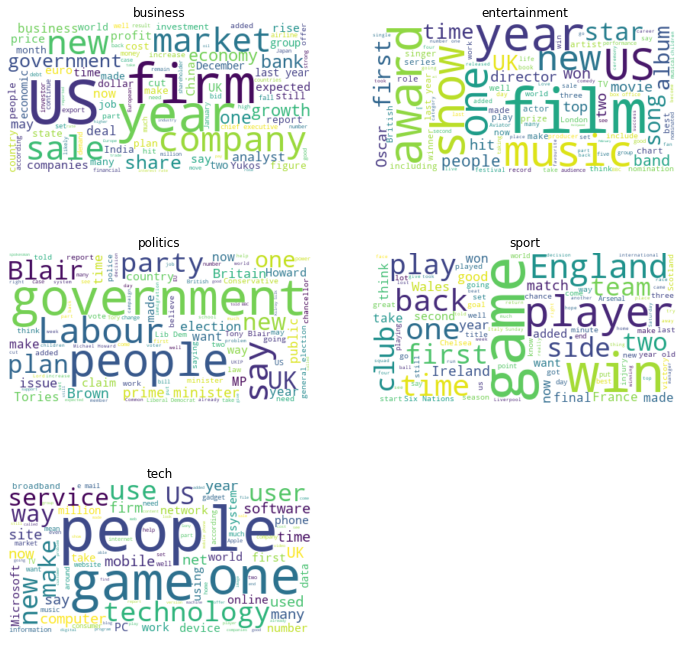

In [30]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))


for ax, cat in zip(axs.ravel()[:5], df['cat_text'].unique()):
    
    word_cloud = WordCloud(max_words=100, stopwords=stopwords, max_font_size=80, background_color='white')

    text = ' '.join(df[df['cat_text'] == cat]['raw_text'].tolist())

    ax.imshow(word_cloud.generate(text), interpolation='bilinear')
    ax.axis('off')
    ax.set_title(cat)
    

_ = axs.ravel()[-1].axis('off')

## 5. Clustering